In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

In [4]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [23]:
death_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
covid19_death = pd.read_csv(death_global,index_col='Country/Region')

In [24]:
df = covid19_death.loc[:,'1/22/20':]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1577,1581,1591,1595,1605,1617,1626,1638,1645,1650
Albania,0,0,0,0,0,0,0,0,0,0,...,579,590,598,605,612,623,631,637,646,657
Algeria,0,0,0,0,0,0,0,0,0,0,...,2077,2093,2111,2124,2139,2154,2168,2186,2206,2224
Andorra,0,0,0,0,0,0,0,0,0,0,...,75,75,75,75,75,76,76,76,76,76
Angola,0,0,0,0,0,0,0,0,0,0,...,308,312,315,317,322,322,324,328,332,333


In [25]:
df = df.transpose()

In [26]:
df = df.sum(axis = 1)

In [27]:
df = df.to_list()

In [28]:
dataset = pd.DataFrame(columns=['ds','y'])

In [29]:
dates = list(covid19_death.columns[3:])

In [30]:
dates = list(pd.to_datetime(dates))

In [31]:
dataset['ds']= dates
dataset['y']= df

In [32]:
dataset = dataset.set_index('ds')

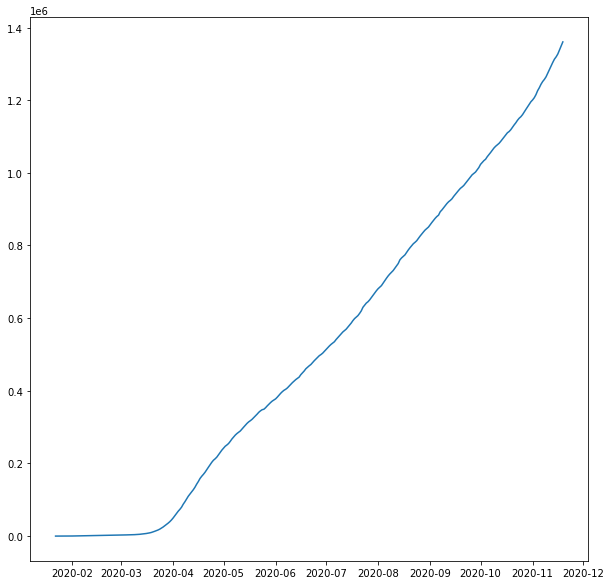

<Figure size 432x288 with 0 Axes>

In [33]:
# daily number of death
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.show()
plt.savefig('Daily Death',bbox_inches = 'tight',transparent = False)

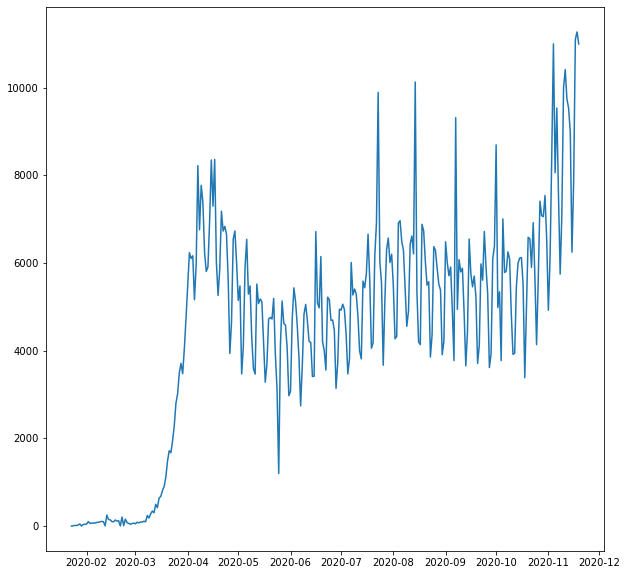

<Figure size 432x288 with 0 Axes>

In [34]:
# daily increase of death
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.show()
plt.savefig('Daily increase death',bbox_inches = 'tight',transparent = False)

In [35]:
# this project will analyze daily increase of death, so change the dataset to
dataset = dataset.diff()

In [36]:
dataset = dataset.loc['2020-01-23':'2020-11-20']

In [37]:
# First time series model attempts: Seasonal AutoRegressive Integrated Moving average(SARIMAX)
# Step 1: separate dataset into training and tesing
start_date = '2020-10-15'
train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

## SARIMAX

In [38]:
# Step 2:  Fit model
# use p=2,q=1,d=3 this three hyperparameters to create the model
model = SARIMAX(train,order = (2,1,3))

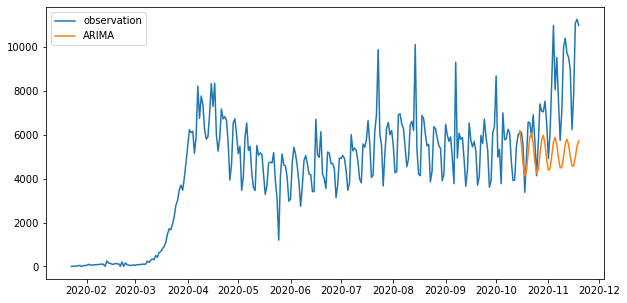

In [39]:
# fit the model
results = model.fit(disp = True)
# make predictions
sarimax_pred = results.predict(start = '2020-10-15', end = '2020-11-19', dynamic= False)
plt.figure(figsize=(10,5))
l1, = plt.plot(dataset,label = 'observation')
l2, = plt.plot(sarimax_pred,label = 'ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX prediction',bbox_inches = 'tight',transparent = False)

In [40]:
mean_absolute_error(sarimax_pred,test)

2347.053034180528

From above plot, we can see that even though the prediction values by this SARIMAX model looks good before the end of October, the second half of the prediction data was still not good enough when we chose p=2,q=1,d=3. So in the next step, we will try to find the best values of p,q and d and minimizing the error.

In [41]:
model = pm.auto_arima(train,start_p=1,start_1=1,
                     test ='adf', # use adftest to find optimal d
                     max_p=5,max_q=5, # maximum p and q
                     m=1,             # frequency of series
                     d=None,         # let model determine d
                     seasonal=False,  # no seasonality
                     start_P=0,
                     D=0,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4437.699, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4493.164, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4482.603, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4458.159, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4491.268, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4436.148, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4434.133, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4417.545, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4340.899, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4335.124, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4433.578, Time=0.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4334.716, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4333.568, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : 

Therefore, the best model for this method is SARIMAX(5,2,4)(0,0,0)[0] 

## Prophet

In [44]:
train['ds'] = train.index.values

In [45]:
# create a Prophet object and use the fit() method
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
pred = m.make_future_dataframe(periods=dataset.shape[0]-train.shape[0])
prophet_pred = m.predict(pred)

In [47]:
prophet_pred = prophet_pred.set_index('ds')
prophet_future = prophet_pred.yhat.loc[prophet_pred.index >= start_date]
mean_absolute_error(prophet_future,test)

1755.7923645475846

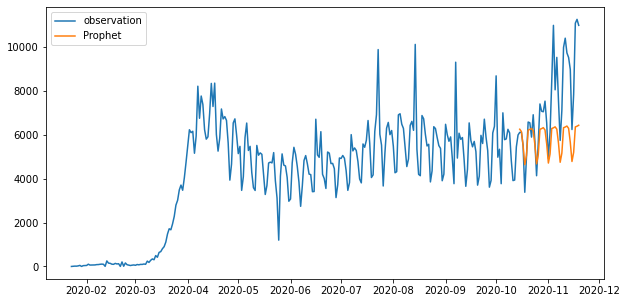

In [48]:
plt.figure(figsize=(10,5))
l11, = plt.plot(dataset,label = 'observation')
l22, = plt.plot(prophet_future,label = 'Prophet')
plt.legend(handles=[l11,l22])
plt.savefig('Prophet prediction',bbox_inches = 'tight',transparent = False)

Prophet has smaller MAE, so it can be better than SARIMAX in terms of model accuracy, but the second half of its prediction value still performs poorly.